In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.utilities import SQLDatabase
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
load_dotenv()

True

In [3]:
from sqlalchemy import create_engine
import os
PG_USER = os.getenv("PG_USER", "postgres")
PG_PASSWORD = os.getenv("PG_PASSWORD", "postgres")
PG_HOST = os.getenv("PG_HOST", "localhost")
PG_PORT = os.getenv("PG_PORT", "5433")
PG_DB = os.getenv("PG_DB", "brickdemand")


uri = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(uri)

# Chỉ để lộ schema/bảng cần thiết để giảm token:
db = SQLDatabase(
    engine=engine,
    # include_tables=["mart.inventory"],
    sample_rows_in_table_info=0, 
    schema="public"
)


In [4]:
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")

login(token=HF_TOKEN)

d:\Study\KLTN\BrickDemand\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
def get_schema(_):
    return db.get_table_info()

print(get_schema(''))


CREATE TABLE public.branch (
	branch_code INTEGER NOT NULL, 
	region TEXT NOT NULL, 
	branch_name TEXT NOT NULL, 
	CONSTRAINT branch_pkey PRIMARY KEY (branch_code)
)


CREATE TABLE public.inventory (
	product_code VARCHAR(128) NOT NULL, 
	branch_code INTEGER NOT NULL, 
	product_name TEXT, 
	unit TEXT, 
	quantity INTEGER NOT NULL, 
	CONSTRAINT inventory_pkey PRIMARY KEY (product_code, branch_code), 
	CONSTRAINT inventory_branch_code_fkey FOREIGN KEY(branch_code) REFERENCES public.branch (branch_code) ON DELETE CASCADE ON UPDATE CASCADE, 
	CONSTRAINT inventory_product_code_fkey FOREIGN KEY(product_code) REFERENCES public.product (product_code) ON DELETE CASCADE ON UPDATE CASCADE, 
	CONSTRAINT inventory_quantity_check CHECK (quantity >= 0)
)


CREATE TABLE public.product (
	product_code VARCHAR(128) NOT NULL, 
	product_name TEXT NOT NULL, 
	category TEXT, 
	f_sku TEXT, 
	spec_code_size TEXT, 
	unit TEXT NOT NULL, 
	CONSTRAINT product_pkey PRIMARY KEY (product_code)
)


CREATE TABLE publi

In [6]:
def run_query(query):
    print(f'Query being run: {query} \n\n')
    return db.run(query)

In [7]:
def get_llm(load_from_hugging_face=False):
    if load_from_hugging_face:
        llm = HuggingFaceEndpoint(
            repo_id="Qwen/Qwen2.5-VL-7B-Instruct",
            task="text-generation",
            provider="hyperbolic",  # set your provider here
        )

        return ChatHuggingFace(llm=llm)
    
    return ChatOpenAI(model="gpt-4o-mini", temperature=0.0)


def write_sql_query(llm):
    template = """Based on the table schema below, write a SQL query that would answer the user's question:
    {schema}

    Question: {question}
    SQL Query:"""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "Given an input question, convert it to a SQL query. No pre-amble. "
            "Please do not return anything else apart from the SQL query, no prefix aur suffix quotes, no sql keyword, nothing please, no ```"),
            ("human", template),
        ]
    )

    return (
        RunnablePassthrough.assign(schema=get_schema)
        | prompt
        | llm
        | StrOutputParser()
    )


In [8]:
def answer_user_query(query, llm):
    template = """Based on the table schema below, question, sql query, and sql response, write a natural language response:
    {schema}

    Question: {question}
    SQL Query: {query}
    SQL Response: {response}"""

    prompt_response = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Given an input question and SQL response, convert it to a natural language answer. Pretty format. No pre-amble.",
            ),
            ("human", template),
        ]
    )

    full_chain = (
        RunnablePassthrough.assign(query=write_sql_query(llm))
        | RunnablePassthrough.assign(
            schema=get_schema,
            response=lambda x: run_query(x["query"]),
        )
        | prompt_response
        | llm
    )

    return full_chain.invoke({"question": query})

In [9]:
# Query types to try out:

# 1. Straight forward queries: Give me the name of 10 Artists
# 2. Querying for multiple columns: Give me the name and artist ID of 10 Artists
# 3. Querying a table by a foreign key: Give me 10 Albums by the Artist with ID 1
# 4. Joining with a different table: Give some Albums by the Artist name Audioslave'
# 5. Multi-level Joins: Give some Tracks by the Artist name Audioslave'

In [10]:
load_dotenv()

# write_sql_query(llm=get_llm(load_from_hugging_face=True)).invoke({"question": "Give me 10 Artists"})
query = 'cho tôi 20 sản phẩm có số lượng tồn kho cao nhất MIỀN TRUNG'
response = answer_user_query(query, llm=get_llm(load_from_hugging_face=True))
print(response.content)

Query being run: SELECT p.product_name, i.quantity 
FROM inventory i 
JOIN product p ON i.product_code = p.product_code 
JOIN branch b ON i.branch_code = b.branch_code 
WHERE b.region = 'MIỀN TRUNG' 
ORDER BY i.quantity DESC 
LIMIT 20; 


The top 20 products with the highest inventory in the MIỀN TRUNG region are:

1. Gạch 30x60 MS 4566 Loại 2 with 85,904 units
2. Gạch 30x60 MS 4551 Loại 2 with 78,400 units
3. Gạch 30x30 MS 3305 Loại 1 with 77,000 units
4. Gạch 60x60 MS 6602 loại 3 with 67,200 units
5. Gạch 30x60 MS 4544 Loại 2 with 67,200 units
6. Gạch 30x60 MS 2901 Loại 2 with 63,952 units
7. Gạch 30x30 MS 3403 Loại 1 with 63,798 units
8. Gạch 30x60 MS USC3603 Loại 2 with 61,936 units
9. Gạch 30x60 MS R3114 Loại 2 with 60,480 units
10. Gạch 30x60 MS 4541 Loại 2 with 60,480 units
11. Keo dán gạch Mapetile Uni Eco Xám with 58,333 units
12. Gạch 30x60 MS 7817 Loại 1 with 56,560 units
13. Gạch 10x33 MS 1301 Loại 1 with 48,188 units
14. Gạch 30x30 MS 3408 Loại 1 with 45,080 units
15. Gạch

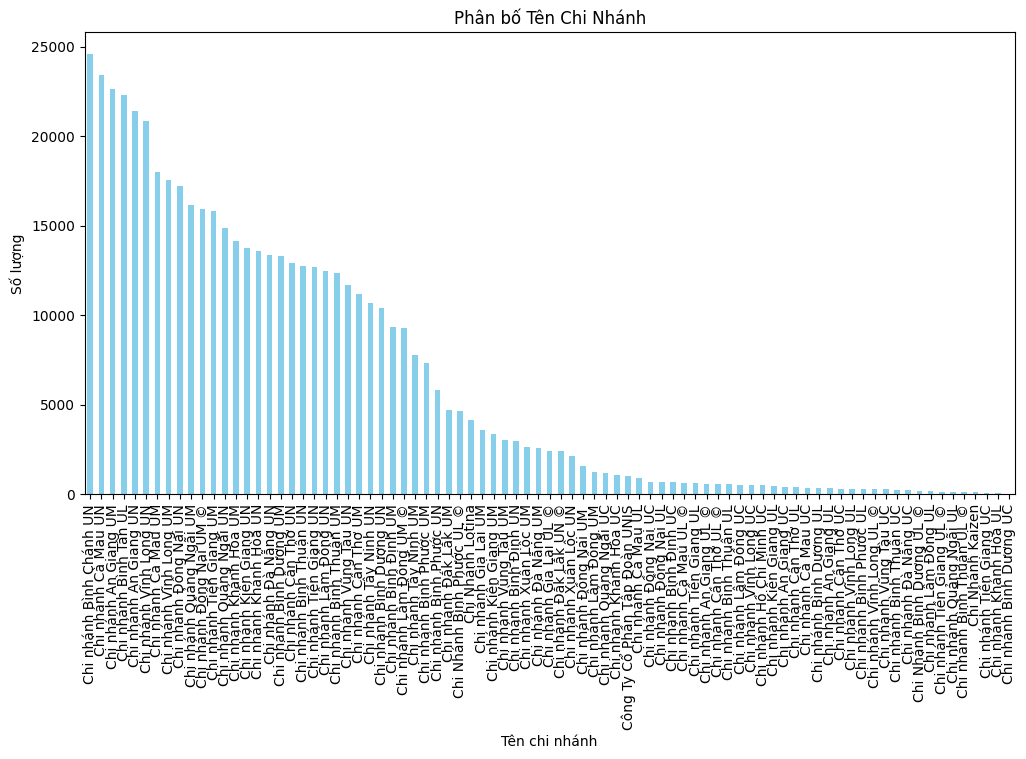

In [22]:
# tạo biểu đồ phân bố Tên Chi Nhánh
branch_counts = df['Tên Chi Nhánh'].value_counts()
branch_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Phân bố Tên Chi Nhánh')
plt.xlabel('Tên chi nhánh')
plt.ylabel('Số lượng')
plt.show()

In [26]:
print(df['Tên Chi Nhánh'].value_counts())
print(df['Mã chi nhánh'].value_counts())

Tên Chi Nhánh
Chi nhánh Bình Chánh UN      24580
Chi nhánh Cà Mau UN          23444
Chi nhánh An Giang UM        22653
Chi nhánh Bình Tân UL        22310
Chi nhánh An Giang UN        21410
                             ...  
Chi nhánh Bình Thuận UL ©      117
Chi Nhánh Kaizen               102
Chi nhánh Tiền Giang UC         91
Chi nhánh Khánh Hòa UL          49
Chi nhánh Bình Dương UC          6
Name: count, Length: 83, dtype: int64
Mã chi nhánh
8      24580
17     23444
50     22653
76     22310
18     21410
       ...  
57       117
85       102
103       91
80        49
109        6
Name: count, Length: 83, dtype: int64


#